In [2]:
import pandas as pd
import numpy as np
import re
from sklearn import metrics
from sklearn.metrics import classification_report
import csv

In [6]:
age_df = pd.read_csv('./data/preprocessed_tweets_with_for_age_pred.csv', lineterminator='\n')
race_df = pd.read_csv('./data/preprocessed_tweets_with_race&age.csv')

In [11]:
race_df.columns

Index(['Unnamed: 0', 'user_id', 'all_tweets', 'is_female', 'year_born',
       'race'],
      dtype='object')

In [8]:
print(age_df['human.labeled.age'].value_counts())
print(race_df['race'].value_counts())

0.0    787
1.0    358
Name: age, dtype: int64
4.0    2534
1.0     299
2.0     186
5.0     120
3.0     102
Name: race, dtype: int64


##### Label formatting for Race data:
4 is white, 1 is black, and merge all other race to 0

In [12]:
race_df.loc[:, 'race'] = np.where(
   (race_df['race'] != 4) & (race_df['race'] != 1) , 0.0, race_df['race']
   )

print(race_df['race'].value_counts())

4.0    2534
0.0     438
1.0     299
Name: race, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_df['text'], train_df['label'], test_size=0.3, stratify=train_df['label'])

### Race prediction using pre-trained BERT model

since Bert Model has a maximum sequence length limit 512

In [13]:
import transformers
import torch
import torch.nn as nn
from transformers import AutoModel, BertTokenizerFast

In [14]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-cased', return_dict=False)
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<AxesSubplot:>

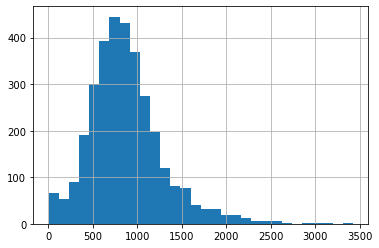

In [16]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in race_df['all_tweets']]
pd.Series(seq_len).hist(bins = 30)

We can clearly see that most of the messages have a length of 25 words or less. Whereas the maximum length is 70. So, if we select 70 as the padding length then all the input sequences will have length 70 and most of the tokens in those sequences will be padding tokens which are not going to help the model learn anything useful and on top of that, it will make the training slower

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(X_train.tolist(), max_length = 25,padding='max_length',truncation=True)

In [ ]:
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(X_val.tolist(), max_length = 25,padding='max_length', truncation=True)

In [ ]:

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
test_df['text'].tolist(),
max_length = 25,
padding='max_length',
truncation=True
)

In [ ]:
## convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_df['label'].tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#define a batch size
batch_size = 32
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert 
        # dropout layer
        self.dropout = nn.Dropout(0.1)
        # relu activation function
        self.relu =  nn.ReLU()
        # dense layer 1
        self.fc1 = nn.Linear(768,512)
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)
        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)
        
    #define the forward pass    
    def forward(self, sent_id, mask):
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        # output layer
        x = self.fc2(x)
        # apply softmax activation
        x = self.softmax(x)
        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
# push the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(),
lr = 1e-5)          # learning rate

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y = y_train)
print("Class Weights:",class_weights)

Class Weights: [1. 1.]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)
# push to GPU
weights = weights.to(device)
# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 
# number of training epochs
epochs = 8

In [ ]:
# function to train the model
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    # empty list to save model predictions
    total_preds=[]
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        
        
        # get model predictions for the current batch
        preds = model(sent_id, mask)
        
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        
        # add on to the total loss
        total_loss += loss.item()
        
        # backward pass to calculate the gradients
        loss.backward()
        
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)
        
        
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
    print("\nEvaluating...")
    # deactivate dropout layers
    model.eval()
    total_loss, total_accuracy = 0, 0
    # empty list to save the model predictions
    total_preds = []
    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            #elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        # push the batch to gpu
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        # deactivate autograd
        with torch.no_grad():
            # model predictions
            preds = model(sent_id, mask)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)
            total_loss += loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
        
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')
# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

Streaming output truncated to the last 5000 lines.
  Batch 1,200  of  35,000.
  Batch 1,250  of  35,000.
  Batch 1,300  of  35,000.
  Batch 1,350  of  35,000.
  Batch 1,400  of  35,000.
  Batch 1,450  of  35,000.
  Batch 1,500  of  35,000.
  Batch 1,550  of  35,000.
  Batch 1,600  of  35,000.
  Batch 1,650  of  35,000.
  Batch 1,700  of  35,000.
  Batch 1,750  of  35,000.
  Batch 1,800  of  35,000.
  Batch 1,850  of  35,000.
  Batch 1,900  of  35,000.
  Batch 1,950  of  35,000.
  Batch 2,000  of  35,000.
  Batch 2,050  of  35,000.
  Batch 2,100  of  35,000.
  Batch 2,150  of  35,000.
  Batch 2,200  of  35,000.
  Batch 2,250  of  35,000.
  Batch 2,300  of  35,000.
  Batch 2,350  of  35,000.
  Batch 2,400  of  35,000.
  Batch 2,450  of  35,000.
  Batch 2,500  of  35,000.
  Batch 2,550  of  35,000.
  Batch 2,600  of  35,000.
  Batch 2,650  of  35,000.
  Batch 2,700  of  35,000.
  Batch 2,750  of  35,000.
  Batch 2,800  of  35,000.
  Batch 2,850  of  35,000.
  Batch 2,900  of  35,000.
  Ba

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))


              precision    recall  f1-score   support

           0       0.88      0.79      0.83       177
           1       0.81      0.90      0.85       182

    accuracy                           0.84       359
   macro avg       0.85      0.84      0.84       359
weighted avg       0.85      0.84      0.84       359



### Naive Bayes Classifier using CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['text'].values)
#vectorizer.vocabulary_
stop_words_vectorizer=CountVectorizer(stop_words='english')
stop_words_vectorizer.fit(train_df['text'].values)

CountVectorizer(stop_words='english')

In [ ]:
X_train=stop_words_vectorizer.transform(train_df['text'].values)
X_test=stop_words_vectorizer.transform(test_df['text'].values)

In [ ]:
nb = MultinomialNB()
nb.fit(X_train,train_df['label'])
y_pred = nb.predict(X_test)
metrics.accuracy_score(test_df["label"].values, y_pred)

print(classification_report(y_true=test_df["label"].values,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       177
           1       0.81      0.81      0.81       182

    accuracy                           0.81       359
   macro avg       0.81      0.81      0.81       359
weighted avg       0.81      0.81      0.81       359

